# Data Preprocessing

## Setup

In [1]:
# make the current working directory the project root directory
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import talib as ta
from tqdm.notebook import tqdm

## Download data

In [3]:
TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']

# 9 years of pre COVID-19 data
TRAIN_START = '2010-01-01'
TRAIN_END = '2019-12-31'

# 1 year of heavily COVID-19 affected data and 1 year of post COVID-19 growth
VAL_START = '2020-01-01'
VAL_END = '2021-12-31'

# 1 year of recession period
TEST_START = '2022-01-01'
TEST_END = '2022-12-31'

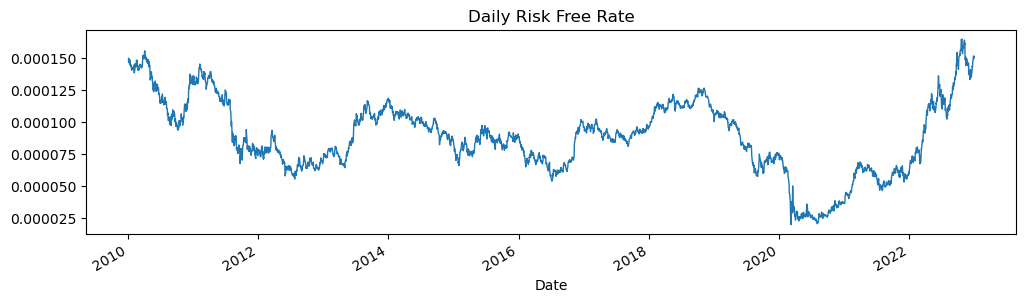

In [4]:
yearly_risk_free_rate_percentage = yf.download('^TNX', start = TRAIN_START, end = TEST_END, interval = '1d', progress=False)['Close']
risk_free_rate = (1+yearly_risk_free_rate_percentage/100)**(1/252)-1 # daily risk free rate
risk_free_rate.plot(title='Daily Risk Free Rate', figsize=(12,3), legend=False, lw=1);

In [5]:
data = {}
for ticker in tqdm(TICKERS):
    data[ticker] = yf.download(
        ticker,
        start = TRAIN_START,
        end = TEST_END,
        interval = '1d',
        progress = False
    )

  0%|          | 0/10 [00:00<?, ?it/s]

## Combine and fill `NaN` values

In [6]:
df = pd.DataFrame(index=pd.date_range(start=TRAIN_START, end=TEST_END, freq='d')) # Create a dataframe with a full index
df['RISK_FREE'] = risk_free_rate
for ticker in TICKERS:
    df[ticker] = data[ticker]['Adj Close'].pct_change(1) # fill in each return column
    df[f'{ticker}_VOLUME'] = data[ticker]['Volume'].pct_change(1)
print(f'Number of all NaN rows dropped: {df.isna().all(axis=1).sum()}')
df.dropna(axis=0, how='all', inplace=True) # drop rows with all NaN e.g first row, weekends, public holidays

Number of all NaN rows dropped: 1476


In [7]:
# Fill `NaN values`
print(df.isna().sum())
df.fillna(value=0, inplace=True) # replace any remaining NaN values with 0 return

RISK_FREE      3
AXP            1
AXP_VOLUME     1
AAPL           1
AAPL_VOLUME    1
BA             1
BA_VOLUME      1
GS             1
GS_VOLUME      1
INTC           1
INTC_VOLUME    1
JNJ            1
JNJ_VOLUME     1
KO             1
KO_VOLUME      1
NKE            1
NKE_VOLUME     1
PG             1
PG_VOLUME      1
DIS            1
DIS_VOLUME     1
dtype: int64


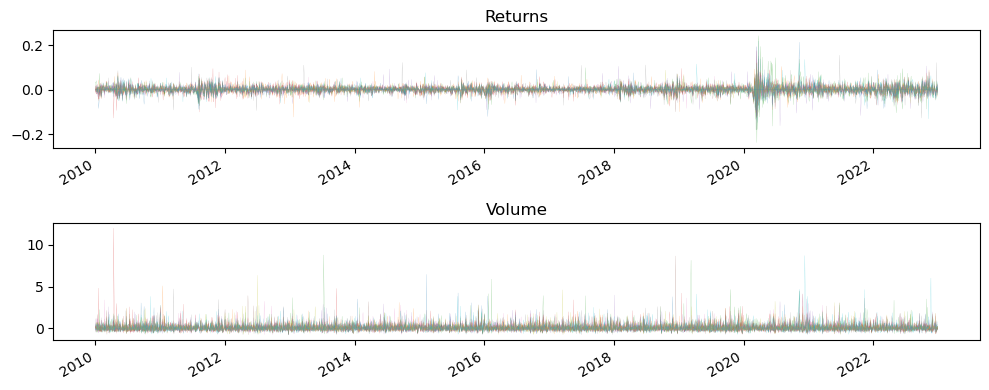

In [8]:
fig, axes = plt.subplots(2)
df[[ticker for ticker in TICKERS] + ['RISK_FREE']].plot(title='Returns', figsize=(10, 4), legend=False, lw=0.1, alpha=0.8, ax=axes[0]);
df[[f'{ticker}_VOLUME' for ticker in TICKERS]].plot(title='Volume', legend=False, lw=0.1, alpha=0.8, ax=axes[1]);
plt.tight_layout()

## Generate Stationary Features

In [9]:
def rolling_cumilative_returns(returns, window=10):
    return np.power((returns+1).rolling(window=window).agg(lambda x : x.prod()), 1/window) - 1

def rolling_std(returns, window=10):
    return returns.rolling(window=window).std()

In [10]:
for ticker in tqdm(TICKERS):
    df[f'{ticker}_RETURN_12'] = rolling_cumilative_returns(df[ticker], 10)
    df[f'{ticker}_RETURN_26'] = rolling_cumilative_returns(df[ticker], 26)
    df[f'{ticker}_RETURN_60'] = rolling_cumilative_returns(df[ticker], 60)
    df[f'{ticker}_STD_20'] = rolling_std(df[ticker], 20)

  0%|          | 0/10 [00:00<?, ?it/s]

## Vizualize Stationary Features

0it [00:00, ?it/s]

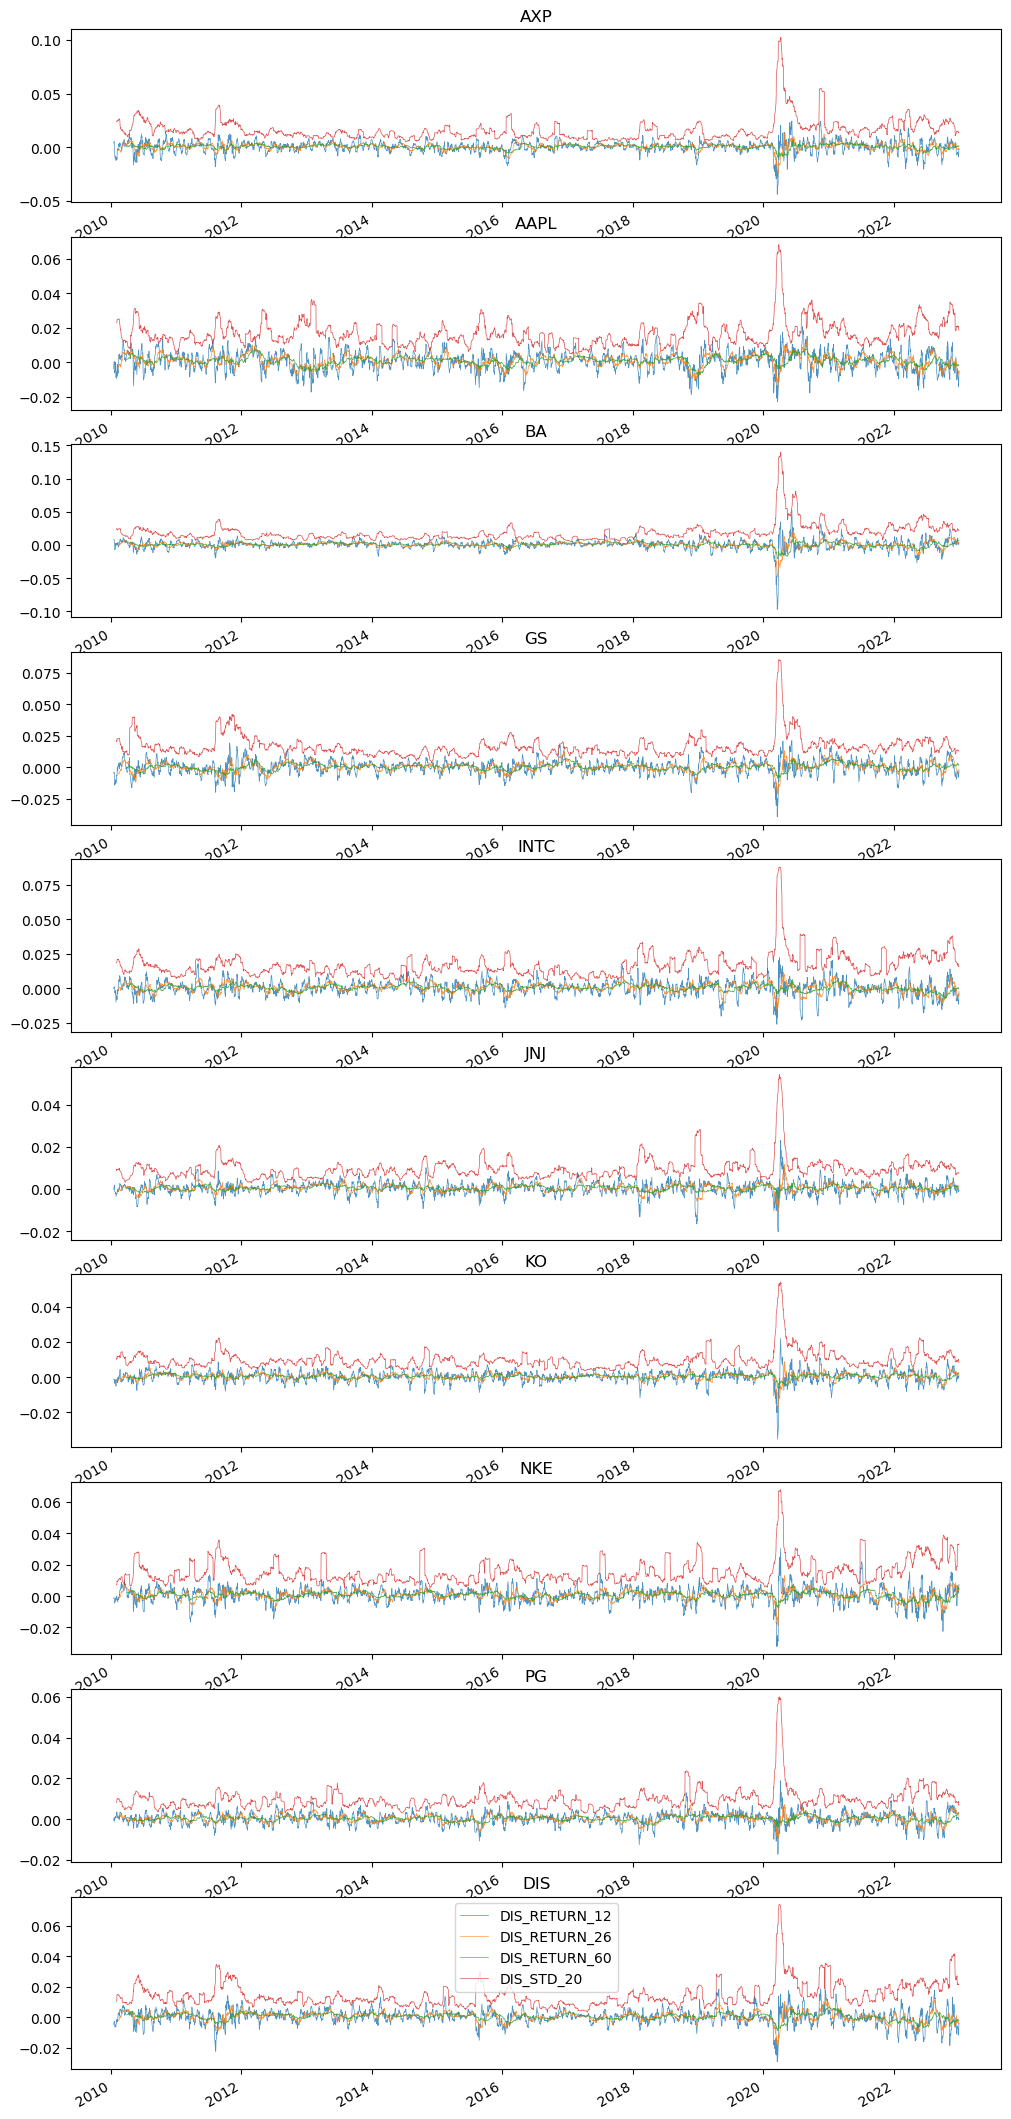

In [11]:
fig, axes = plt.subplots(len(TICKERS), figsize=(12, len(TICKERS)*3))
for i, ticker in tqdm(enumerate(TICKERS)):
    features = [f'{ticker}_RETURN_12', f'{ticker}_RETURN_26', f'{ticker}_RETURN_60', f'{ticker}_STD_20']
    df[features].plot(title=ticker, legend=False, lw=0.5, alpha=0.8, ax=axes[i]);
plt.legend();

## Drop `NaN` Values

In [12]:
df.isna().sum()

RISK_FREE         0
AXP               0
AXP_VOLUME        0
AAPL              0
AAPL_VOLUME       0
                 ..
PG_STD_20        19
DIS_RETURN_12     9
DIS_RETURN_26    25
DIS_RETURN_60    59
DIS_STD_20       19
Length: 61, dtype: int64

In [13]:
df = df.dropna()

In [14]:
df.shape

(3213, 61)

## Train-Val-Test Split

In [15]:
train_df = df[TRAIN_START : TRAIN_END]
val_df = df[VAL_START : VAL_END]
test_df = df[TEST_START : TEST_END]

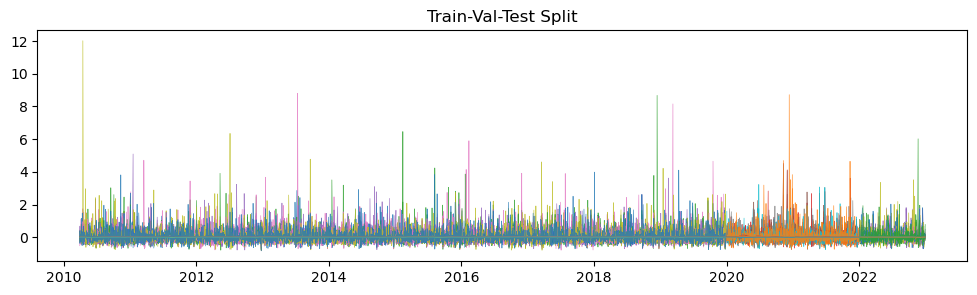

In [16]:
plt.figure(figsize=(12,3));
plt.title('Train-Val-Test Split')
plt.plot(train_df, alpha=0.8, lw=0.5);
plt.plot(val_df, alpha=0.8, lw=0.5);
plt.plot(test_df, alpha=0.8, lw=0.5);

In [17]:
df.to_csv('data/dow_10_stationary_features.csv')
train_df.to_csv('data/dow_10_stationary_features_train.csv')
val_df.to_csv('data/dow_10_stationary_features_val.csv')
test_df.to_csv('data/dow_10_stationary_features_test.csv')